# Design of Experiments (DoE)

Play along using the process simulation tool from the link:
https://sigmazone.com/dual-catapult/

## Experiments which deliver lots of insights with a minimum number of process test runs.
A powerful tool used in Lean Six Sigma methodology, typically in the Analyze and Improve phases.

## Business questions to answer:

* How can process output be predicted by process inputs?: Modeling.
* How can process input be predicted given a target process output?: Modeling.
* Which process inputs have greater influence on process output values?. Screening
* Which process inputs have greater influence on process output variability?. Screening
* Help me understand the process and where I should invest for better performance (controls, training...)

## Comments on Python:
* Care has been taken to use free software (Python) and free libraries (numpy, pandas, matplotlib, statsmodels, scipy)
* Some parts of code have used different approaches, just to show some different ways of coding (some are better, obviously)

# Importing libraries

In [171]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt  # Graphics (normal)
plt.style.use('seaborn-v0_8') # Style for matplotlib charts (optional, but makes easier to read charts)
plt.rcParams['figure.figsize'] = [9.3, 3.5] # Size for matplotlib charts (optional, but useful) 

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera, omni_normtest

from scipy.stats import t

from scipy.optimize import minimize

# Understanding the problem

* Factors: 6 (process input variables)
* Levels: 2 (values for each factor, considering range (distance between levels) which makes sense for problem)
* Response variables: 1 (process output variables)
* Sample size: to be defined (number of repetitions for each trial settings)

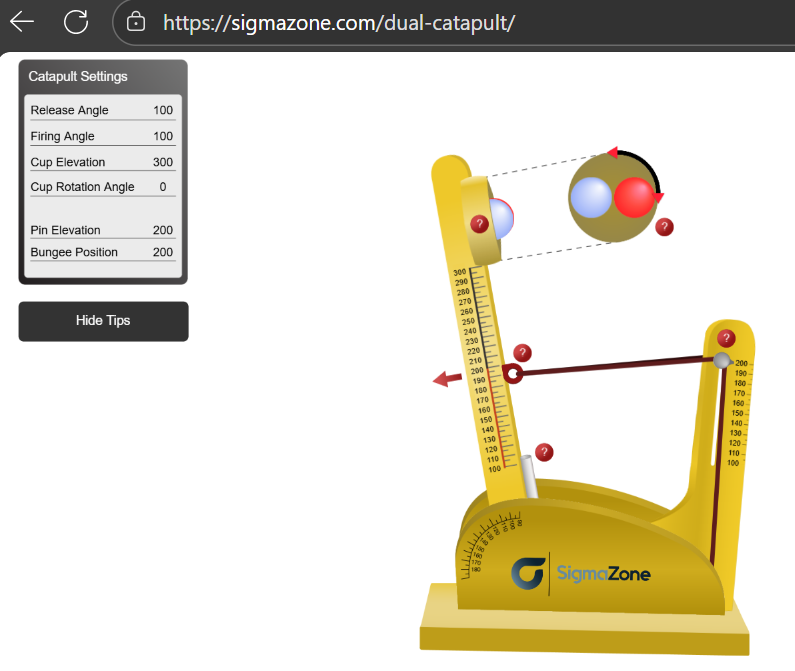

# Choosing the experimental design

## Instructions

* Up to 4 factors, 2 levels each: full factorial experiment, can be used for modeling:
  * Factors: 2, Levels: 2: 2^2 = 4 run full factorial.  Minimum sample size (for each factor combination): 9. Total of measurements: 9 * 4  = 36
  * Factors: 3, Levels: 2: 2^3 = 8 run full factorial.  Minimum sample size (for each factor combination): 5. Total of measurements: 5 * 8  = 40
  * Factors: 4, Levels: 2: 2^4 = 16 run full factorial. Minimum sample size (for each factor combination): 3. Total of measurements: 3 * 16 = 48
* 5 factors, 2 level each: half factorial experiment, can be used for modeling:
  * Factors: 5, Levels: 2: 2^(5-1) = 16 run half factorial. Minimum sample size (for each factor combination): 3. Total of measurements: 3 * 16 = 48
* From 6 up to 11 factors, 2 levels each: Taguchi L12 experiment, can be used for screening only (if modeling is needed, new experiment to be set):
  * Factors: 6 to 11, Levels: 2, runs: 12. Minimum sample size (for each factor combination): 4. Total of measurements: 4 * 12 = 48 

Experiment of choice:

Taguchi L12 experiment for 6 factors and 2 levels, with 12 runs and 4 measurements for each run (4 measurements is the minimum, it could be more)

This is the matrix to create (desconsider factor columns which are not going to be used).

Data source: https://www.york.ac.uk/depts/maths/tables/l12.gif

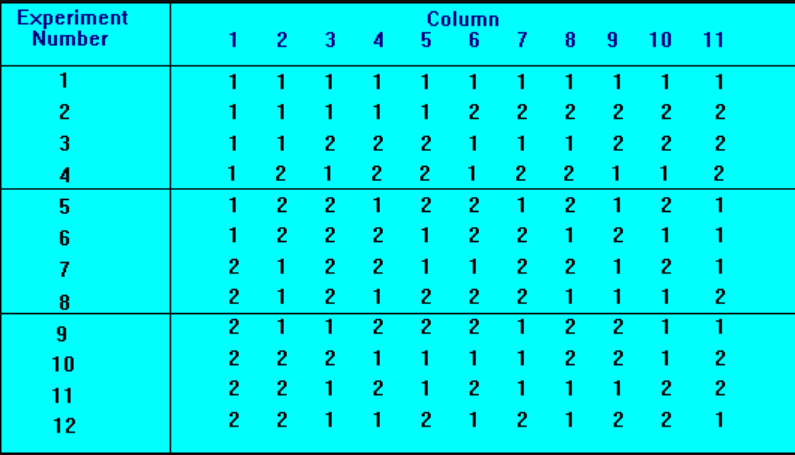

## Data preparation

Matrix data

In [172]:
factor_number = 6

factor_1 = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
factor_2 = [1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2]
factor_3 = [1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1]
factor_4 = [1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1]
factor_5 = [1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2]
factor_6 = [1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1]

run_number = len(factor_1)

factor_number_list = []

for i in range(1, factor_number + 1):
    factor_number_list.append(f'factor_{i}')

Factor levels

In [173]:
settings_factor_1 = [150, 180]
settings_factor_2 = [110, 130]
settings_factor_3 = [250, 300]
settings_factor_4 = [0, 90]
settings_factor_5 = [130, 200]
settings_factor_6 = [150, 200]

In [174]:
for factor in factor_number_list:
    f = factor[-1]                          # f: factor index; i: run index
    for i in range(run_number):
        if globals()[factor][i] == 1:
            globals()[factor][i] = globals()[f'settings_factor_{f}'][0]
        else:
            globals()[factor][i] = globals()[f'settings_factor_{f}'][1]
    

In [175]:
for factor in factor_number_list:
    print(globals()[factor])

[150, 150, 150, 150, 150, 150, 180, 180, 180, 180, 180, 180]
[110, 110, 110, 130, 130, 130, 110, 110, 110, 130, 130, 130]
[250, 250, 300, 250, 300, 300, 300, 300, 250, 300, 250, 250]
[0, 0, 90, 90, 0, 90, 90, 0, 90, 0, 90, 0]
[130, 130, 200, 200, 200, 130, 130, 200, 200, 130, 130, 200]
[150, 200, 150, 150, 200, 200, 150, 200, 200, 150, 200, 150]


In [176]:
name_factor_1 = 'A_release'
name_factor_2 = 'B_firing'
name_factor_3 = 'C_cup_e'
name_factor_4 = 'D_cup_r'
name_factor_5 = 'E_pin'
name_factor_6 = 'F_bungee'

In [177]:
data = pd.DataFrame({'run_count': list(range(1, run_number + 1))})

In [178]:
for i in range(1, factor_number+1):
    data[globals()[f'name_factor_{i}']] = globals()[f'factor_{i}']


In [179]:
data

,run_count,A_release,B_firing,C_cup_e,D_cup_r,E_pin,F_bungee
0,1,150,110,250,0,130,150
1,2,150,110,250,0,130,200
2,3,150,110,300,90,200,150
3,4,150,130,250,90,200,150
4,5,150,130,300,0,200,200
5,6,150,130,300,90,130,200
6,7,180,110,300,90,130,150
7,8,180,110,300,0,200,200
8,9,180,110,250,90,200,200
9,10,180,130,300,0,130,150


## Getting data from experiments

4 tests for each run is required at least.

Tests run at: https://sigmazone.com/dual-catapult/

Save test result data here

Rsults may vary from experiment to experiment

In [180]:
run_1 = [176, 179, 176, 177]
run_2 = [209, 211, 209, 211]
run_3 = [277, 324, 281, 328]
run_4 = [123, 156, 122, 157]
run_5 = [220, 224, 222, 227]
run_6 = [136, 164, 138, 159]
run_7 = [307, 363, 310, 359]
run_8 = [570, 572, 576, 579]
run_9 = [403, 503, 406, 508]
run_10 = [282, 284, 281, 284]
run_11 = [300, 377, 298, 375]
run_12 = [343, 344, 339, 339]

n_test = len(run_1)

Preparing data format

In [181]:
rows = []

for i in list(range(1, run_number + 1)):
    rows.append(globals()[f'run_{i}'])


columns = []
for i in list(range(1, n_test + 1)):
    columns.append(f'y_{i}')

test_df = pd.DataFrame(rows, columns=columns)

data = pd.concat([data, test_df], axis='columns')

In [182]:
data['y_mean'] = data[columns].mean(axis='columns')
data['y_std'] = data[columns].std(axis='columns')

In [183]:
data

,run_count,A_release,B_firing,C_cup_e,D_cup_r,E_pin,F_bungee,y_1,y_2,y_3,y_4,y_mean,y_std
0,1,150,110,250,0,130,150,176,179,176,177,177.00,1.414214
1,2,150,110,250,0,130,200,209,211,209,211,210.00,1.154701
2,3,150,110,300,90,200,150,277,324,281,328,302.50,27.233558
3,4,150,130,250,90,200,150,123,156,122,157,139.50,19.638398
4,5,150,130,300,0,200,200,220,224,222,227,223.25,2.986079
5,6,150,130,300,90,130,200,136,164,138,159,149.25,14.314911
6,7,180,110,300,90,130,150,307,363,310,359,334.75,30.379544
7,8,180,110,300,0,200,200,570,572,576,579,574.25,4.031129
8,9,180,110,250,90,200,200,403,503,406,508,455.00,58.360946
9,10,180,130,300,0,130,150,282,284,281,284,282.75,1.500000


# Standard deviation. Marginal mean plots

## Business question: what inputs of the process cause more output variability?

Moreover:
* How can I set process input parameters to minimize process output variability?

Filtering relevant data

In [184]:
columns = []

for i in list(range(1, factor_number + 1)):
    columns.append(globals()[f'name_factor_{i}'])

In [185]:
worksheet = data[columns].copy()
worksheet['stddev'] = data.y_std

In [186]:
worksheet.head(3)

,A_release,B_firing,C_cup_e,D_cup_r,E_pin,F_bungee,stddev
0,150,110,250,0,130,150,1.414214
1,150,110,250,0,130,200,1.154701
2,150,110,300,90,200,150,27.233558


In [187]:
data_analysis = pd.DataFrame(
                            {
                                'min_factor': [worksheet[i].min() for i in worksheet.columns[:-1]],
                                'max_factor': [worksheet[i].max() for i in worksheet.columns[:-1]]
                             }, 
                             index=worksheet.columns[:-1]
                            )

In [188]:
display(data_analysis)

,min_factor,max_factor
A_release,150,180
B_firing,110,130
C_cup_e,250,300
D_cup_r,0,90
E_pin,130,200
F_bungee,150,200


Complete the table, show the table and its visualization

In [189]:
stddev_mean_min_of_factor = []
for factor in data_analysis.index.tolist():
    min_value_of_factor = data_analysis.loc[factor, 'min_factor']
    stddev_mean_min = worksheet.loc[worksheet[factor] == min_value_of_factor].stddev.mean()
    stddev_mean_min_of_factor.append(stddev_mean_min)

stddev_mean_max_of_factor = []
for factor in data_analysis.index.tolist():
    max_value_of_factor = data_analysis.loc[factor, 'max_factor']
    stddev_mean_max = worksheet.loc[worksheet[factor] == max_value_of_factor].stddev.mean()
    stddev_mean_max_of_factor.append(stddev_mean_max)

data_analysis['stddev_mean_min_factor'] = stddev_mean_min_of_factor
data_analysis['stddev_mean_max_factor'] = stddev_mean_max_of_factor

data_analysis['delta_abs'] = abs(data_analysis.stddev_mean_min_factor - data_analysis.stddev_mean_max_factor)

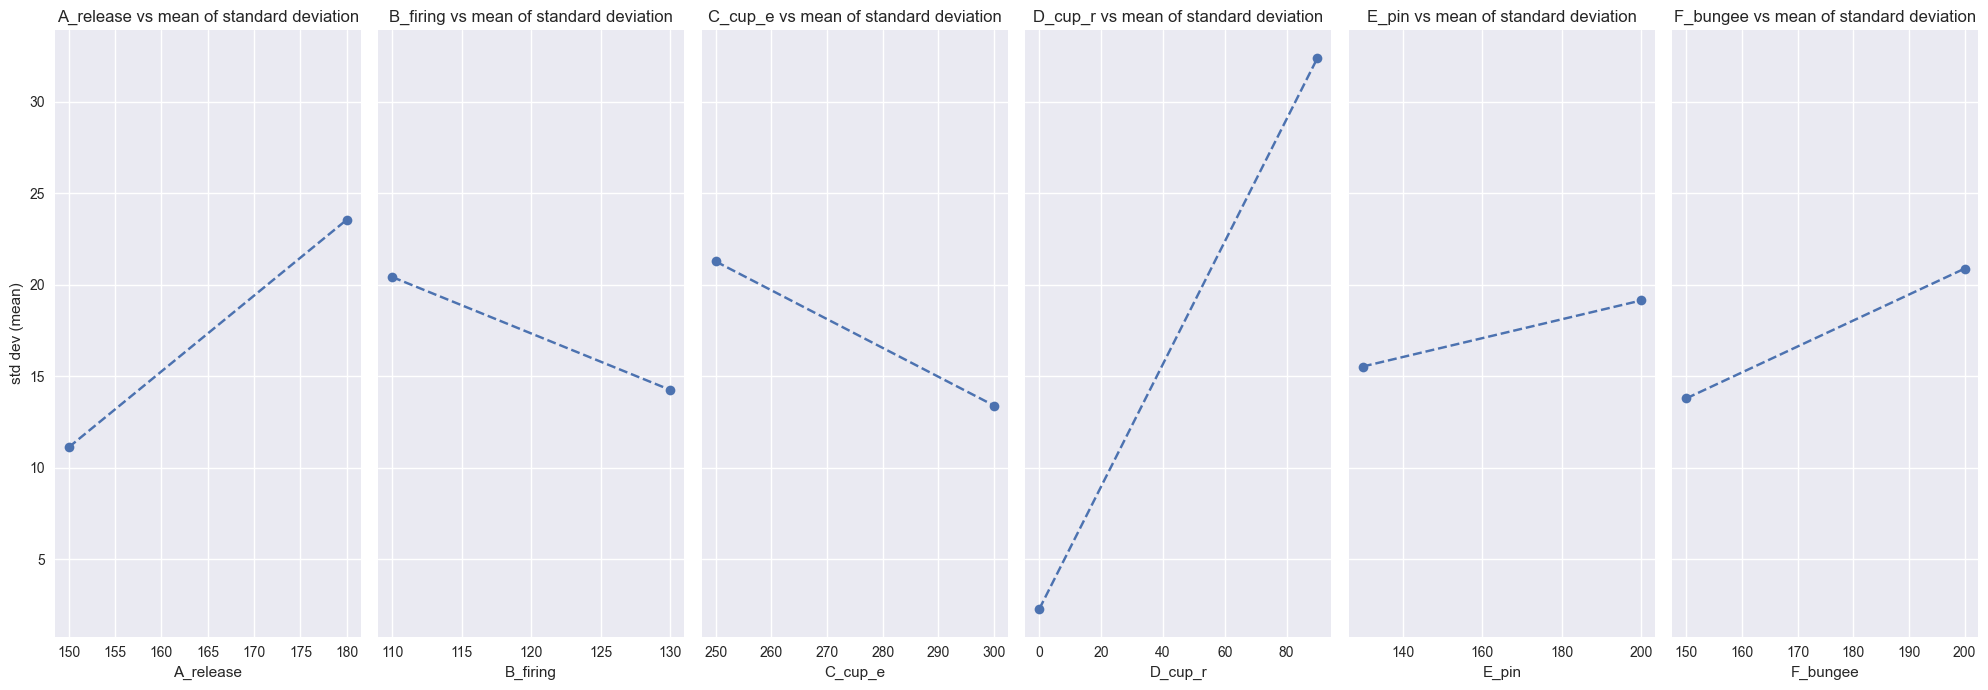

,min_factor,max_factor,stddev_mean_min_factor,stddev_mean_max_factor,delta_abs
D_cup_r,0,90,2.286013,32.399720,30.113707
A_release,150,180,11.123643,23.562090,12.438447
C_cup_e,250,300,21.278196,13.407537,7.870660
F_bungee,150,200,13.799278,20.886455,7.087177
B_firing,110,130,20.429015,14.256718,6.172297
E_pin,130,200,15.539055,19.146677,3.607622


In [190]:
fig, axes = plt.subplots(1, len(data_analysis.index.tolist()), figsize=(20, 7), sharey=True)

for i, factor in enumerate(data_analysis.index.tolist()):
    filtered = data_analysis.loc[factor]
    axes[i].plot(
        [filtered.min_factor, filtered.max_factor],
        [filtered.stddev_mean_min_factor, filtered.stddev_mean_max_factor],
        marker='o', linestyle = '--'
    )
    axes[i].set_title(f'{factor} vs mean of standard deviation')
    axes[i].set_xlabel(factor)
    if i == 0:
        axes[i].set_ylabel('std dev (mean)')

plt.tight_layout()
plt.show()
print()
display(data_analysis.sort_values(by='delta_abs', ascending= False))

## Conclusions for standard deviation
Marginal mean plot

* Try to get factor D_cup_rotation in their lower level (0) in order to minimize variance of process
* Rest of factors have a similar, lower influence in the variance of process

# Output variable. Marginal mean plots

## Business question: what inputs of the process cause more impact in output?

Moreover:

* Which input variables can be modified slightly and cause greater change in output?
* Is some input variable which can be set to cheaper, faster, easier values without affecting process output?

Filtering relevant data

In [191]:
columns = []

for i in list(range(1, factor_number + 1)):
    columns.append(globals()[f'name_factor_{i}'])

In [192]:
worksheet = data[columns].copy()
worksheet['y_mean'] = data.y_mean

In [193]:
worksheet.head(3)

,A_release,B_firing,C_cup_e,D_cup_r,E_pin,F_bungee,y_mean
0,150,110,250,0,130,150,177.0
1,150,110,250,0,130,200,210.0
2,150,110,300,90,200,150,302.5


In [194]:
data_analysis = pd.DataFrame(
                            {
                                'min_factor': [worksheet[i].min() for i in worksheet.columns[:-1]],
                                'max_factor': [worksheet[i].max() for i in worksheet.columns[:-1]]
                             }, 
                             index=worksheet.columns[:-1]
                            )

In [195]:
data_analysis

,min_factor,max_factor
A_release,150,180
B_firing,110,130
C_cup_e,250,300
D_cup_r,0,90
E_pin,130,200
F_bungee,150,200


In [196]:
y_mean_min_of_factor = []
for factor in data_analysis.index.tolist():
    min_value_of_factor = data_analysis.loc[factor, 'min_factor']
    y_mean_min = worksheet.loc[worksheet[factor] == min_value_of_factor].y_mean.mean()
    y_mean_min_of_factor.append(y_mean_min)

y_mean_max_of_factor = []
for factor in data_analysis.index.tolist():
    max_value_of_factor = data_analysis.loc[factor, 'max_factor']
    y_mean_max = worksheet.loc[worksheet[factor] == max_value_of_factor].y_mean.mean()
    y_mean_max_of_factor.append(y_mean_max)

data_analysis['y_mean_min_factor'] = y_mean_min_of_factor
data_analysis['y_mean_max_factor'] = y_mean_max_of_factor

data_analysis['delta_abs'] = abs(data_analysis.y_mean_min_factor - data_analysis.y_mean_max_factor)

In [197]:
data_analysis

,min_factor,max_factor,y_mean_min_factor,y_mean_max_factor,delta_abs
A_release,150,180,200.250000,387.583333,187.333333
B_firing,110,130,342.250000,245.583333,96.666667
C_cup_e,250,300,276.708333,311.125000,34.416667
D_cup_r,0,90,301.416667,286.416667,15.000000
E_pin,130,200,248.541667,339.291667,90.750000
F_bungee,150,200,262.958333,324.875000,61.916667


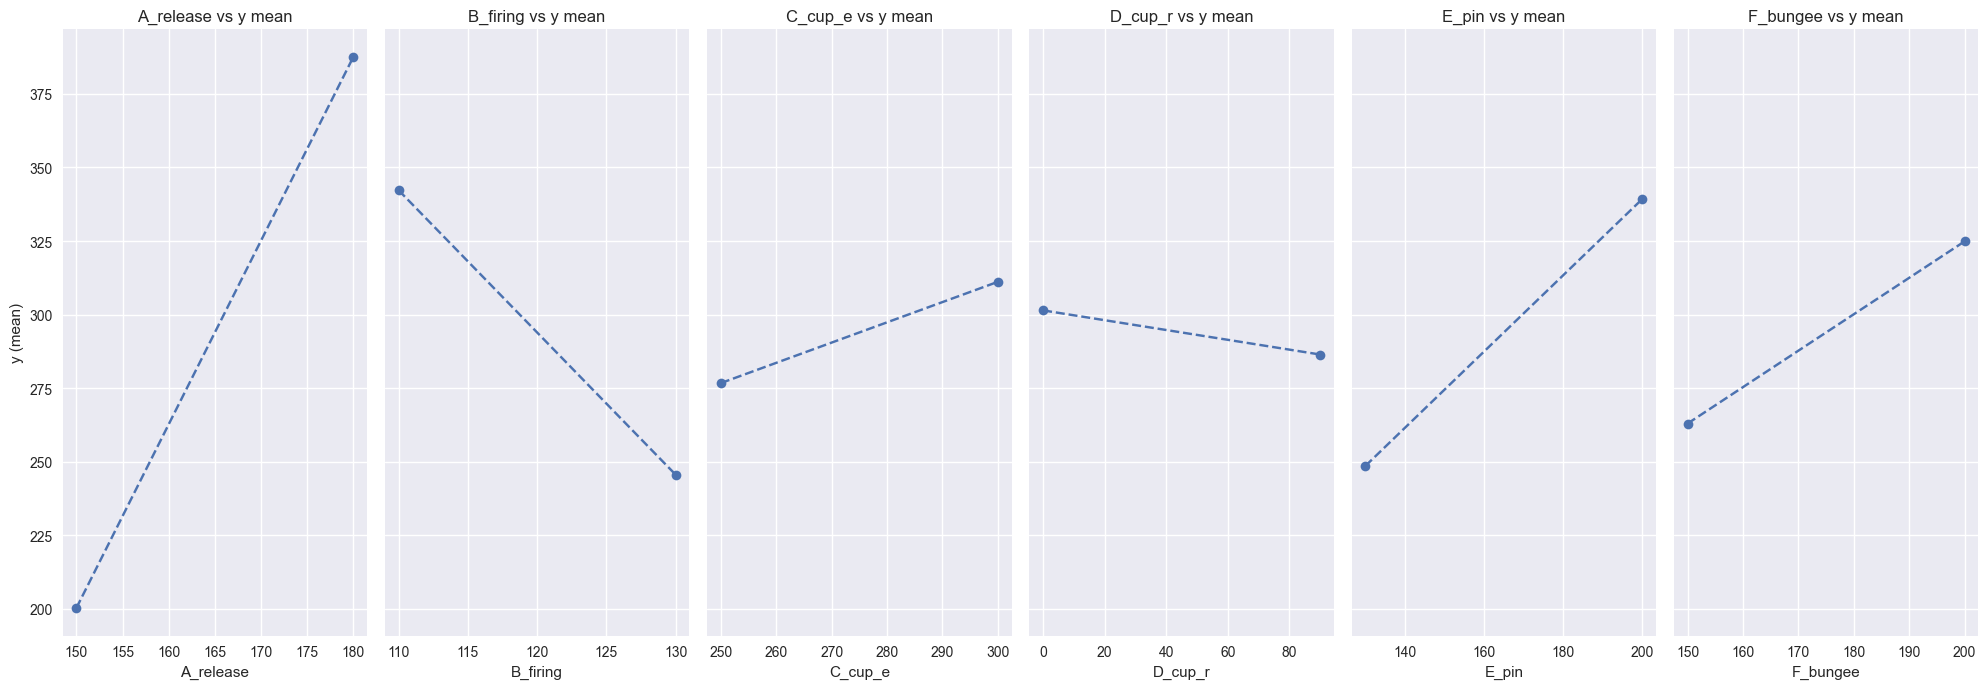

,min_factor,max_factor,y_mean_min_factor,y_mean_max_factor,delta_abs
A_release,150,180,200.250000,387.583333,187.333333
B_firing,110,130,342.250000,245.583333,96.666667
E_pin,130,200,248.541667,339.291667,90.750000
F_bungee,150,200,262.958333,324.875000,61.916667
C_cup_e,250,300,276.708333,311.125000,34.416667
D_cup_r,0,90,301.416667,286.416667,15.000000


In [198]:
fig, axes = plt.subplots(1, len(data_analysis.index.tolist()), figsize=(20, 7), sharey=True)

for i, factor in enumerate(data_analysis.index.tolist()):
    filtered = data_analysis.loc[factor]
    axes[i].plot(
        [filtered.min_factor, filtered.max_factor],
        [filtered.y_mean_min_factor, filtered.y_mean_max_factor],
        marker='o', linestyle = '--'
    )
    axes[i].set_title(f'{factor} vs y mean')
    axes[i].set_xlabel(factor)
    if i == 0:
        axes[i].set_ylabel('y (mean)')

plt.tight_layout()
plt.show()
print()
display(data_analysis.sort_values(by='delta_abs', ascending= False))

## Conclusions for Output variable

Output variable mean plot

* Factor A_release angle is key in this process, will be included for process modeling
  * Factor A_release: for new full factorial experiment 
* Factors B_firing and E_pin also have big influence in the process output, will be included for process modeling
  * Factor B_firing: for new full factorial experiment
  * Factor E_pin: for new full factorial experiment 
* Factor D_cup_r rotation can be fixed to min value (0) to minimize process output variance
  * Factor D_cup: 0
* Factor C_cup_e and F_bungee, will be excluded for process modeling, let's fix their value:
  * Unless other requirements stated (ease to implement, lower cost, faster process, better quality...) middle value is a nice thing to use
  * Factor C_cup_e: 275
  * Factor F_bungee: 175
  * These two factors could have been used for a full factorial design of experiments, but we will use only 3 factors this time

# Modeling of process

## Full factorial experiment

* 3 Factors
* 2 Levels

Factors: 3 (A_release, B_firing, E_pin)
* A_release: 150, 180
* B_firing: 110, 130
* E_pin: 130, 200

Fixed process input variables:
* Factor D_cup_r: 0 (to keep process variance low)
* Factor C_cup_e: 275
* Factor F_bungee: 175

This experiment can be used for process modeling.

Experiment of choice:

Full factorial experiment for 3 factors and 2 levels, with 12 runs and 4 measurements for each run (4 measurements is the minimum, it could be more)

This is the matrix to create.

Data source: https://www.mathworks.com/help/stats/ff2n.html

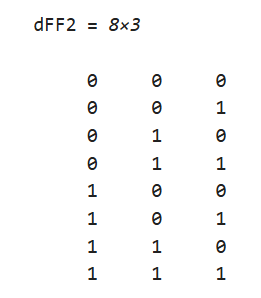

In [199]:
factor_number = 3
run_number = 8

factor_data = data_analysis.sort_values(by='delta_abs', ascending= False).iloc[0:factor_number, 0:2]

In [200]:
factor_data

,min_factor,max_factor
A_release,150,180
B_firing,110,130
E_pin,130,200


In [201]:
data = pd.DataFrame(list(range(1, run_number + 1)),
                    columns=['run_count']
                    )

ff_matrix = [
             [0, 0, 0],
             [0, 0, 1],
             [0, 1, 0],
             [0, 1, 1],
             [1, 0, 0],
             [1, 0, 1],
             [1, 1, 0],
             [1, 1, 1],
]

ff_matrix = pd.DataFrame(ff_matrix, columns=factor_data.index)

data = pd.concat([data, ff_matrix], axis='columns')

In [202]:
data

,run_count,A_release,B_firing,E_pin
0,1,0,0,0
1,2,0,0,1
2,3,0,1,0
3,4,0,1,1
4,5,1,0,0
5,6,1,0,1
6,7,1,1,0
7,8,1,1,1


In [203]:
for factor in factor_data.index.tolist():
    data.loc[data[factor] == 0, factor] = factor_data.loc[factor_data.index == factor, 'min_factor'].iloc[0]
    data.loc[data[factor] == 1, factor] = factor_data.loc[factor_data.index == factor, 'max_factor'].iloc[0]

In [204]:
data

,run_count,A_release,B_firing,E_pin
0,1,150,110,130
1,2,150,110,200
2,3,150,130,130
3,4,150,130,200
4,5,180,110,130
5,6,180,110,200
6,7,180,130,130
7,8,180,130,200


## Getting data from experiments

5 tests for each run is required at least.


Factors: 3, Levels: 2: 2^3 = 8 run full factorial. Minimum sample size (for each factor combination): 5. Total of measurements: 5 * 8 = 40

Tests run at: https://sigmazone.com/dual-catapult/

In [205]:
run_1 = [216, 218, 221, 223, 219, 221]
run_2 = [301, 301, 303, 305, 306, 308]
run_3 = [119, 122, 122, 125, 120, 120]
run_4 = [181, 183, 187, 190, 184, 187]
run_5 = [333, 336, 331, 334, 331, 333]
run_6 = [472, 473, 472, 474, 472, 475]
run_7 = [286, 286, 284, 284, 285, 285]
run_8 = [430, 433, 433, 435, 435, 435]

sample_number = len(run_1)

Checking visually that data from experiments is OK

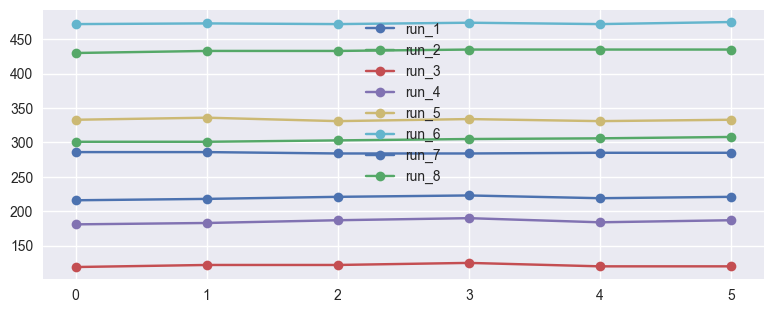

In [206]:
for i in list(range(1, run_number+1)):
    plt.plot(globals()[f'run_{i}'], marker='o', label=f'run_{i}')
    plt.legend(loc='best')
plt.show()

## Regression analysis of output variable

### Business question: how can I predict output of the process with the values of the input variables?

Moreover: 
* Which of the chosen input variables might not be relevant?
* Are some input variables correlated?
* Using this model, how can this process be optimized (example: maximize output minimizing some input constraints)?

Using all test data gives more information regarding confidence interval of values and the computational requirement are almost the same.

### Preparing data

In [207]:
data_regression = pd.DataFrame()

for i in list(range(0, sample_number)):
    filtered_df = data[factor_data.index].copy()
    data_regression = pd.concat([data_regression, filtered_df], axis=0, ignore_index=True)

Create list of lists of experiment results

In [208]:
run_together = []

# Loop through each list and each item inside (list of lists)
for i in list(range(1, run_number+1)):
    run_together.append(globals()[f'run_{i}'])

In [209]:
run_together

[[216, 218, 221, 223, 219, 221],
 [301, 301, 303, 305, 306, 308],
 [119, 122, 122, 125, 120, 120],
 [181, 183, 187, 190, 184, 187],
 [333, 336, 331, 334, 331, 333],
 [472, 473, 472, 474, 472, 475],
 [286, 286, 284, 284, 285, 285],
 [430, 433, 433, 435, 435, 435]]

Transpose these data

In [210]:
list(zip(*run_together))

[(216, 301, 119, 181, 333, 472, 286, 430),
 (218, 301, 122, 183, 336, 473, 286, 433),
 (221, 303, 122, 187, 331, 472, 284, 433),
 (223, 305, 125, 190, 334, 474, 284, 435),
 (219, 306, 120, 184, 331, 472, 285, 435),
 (221, 308, 120, 187, 333, 475, 285, 435)]

Flatten the transposed list

In [211]:
run_together = [item for row in list(zip(*run_together)) for item in row]

Checking that everything is going fine

In [212]:
print(f'Is everything going fine?: {len(run_together) == len(data_regression)}')

Is everything going fine?: True


Join test results to test data

In [213]:
data_regression['y'] = run_together

### Regression model

In [214]:
data_regression.columns

Index(['A_release', 'B_firing', 'E_pin', 'y'], dtype='object')

In [215]:
model = smf.ols(formula='y ~ A_release * B_firing * E_pin', data=data_regression).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.742e+04
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           1.37e-67
Time:                        18:45:53   Log-Likelihood:                -102.06
No. Observations:                  48   AIC:                             220.1
Df Residuals:                      40   BIC:                             235.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

Parameter 'A_release:B_firing:E_pin' must be eliminated (requirement of full factorial)

In [216]:
model.params.index.tolist()[1:-1]

['A_release',
 'B_firing',
 'A_release:B_firing',
 'E_pin',
 'A_release:E_pin',
 'B_firing:E_pin']

In [217]:
param_text = ", ".join(model.params.index.tolist()[1:-1])

# Step-by-step transformation
transformed = param_text.replace("'", "")       # Remove single quotes
transformed = transformed.replace(",", " +")  # Replace commas with ' + '
#transformed = transformed.replace(":", "*")    # Replace colons with '*'

print(transformed)

A_release + B_firing + A_release:B_firing + E_pin + A_release:E_pin + B_firing:E_pin


In [218]:
model = smf.ols(formula='y ~ A_release + B_firing + A_release:B_firing + E_pin + A_release:E_pin + B_firing:E_pin', data=data_regression).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     5006.
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           4.37e-57
Time:                        18:45:53   Log-Likelihood:                -136.25
No. Observations:                  48   AIC:                             286.5
Df Residuals:                      41   BIC:                             299.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2500.8571     99

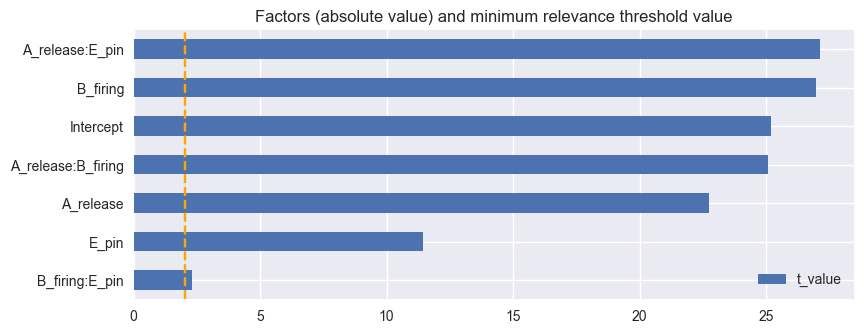

,coefficient,p_value
B_firing:E_pin,-0.004226,2.723282e-02
E_pin,-3.439286,2.539873e-14
A_release,-12.671825,7.089807e-25
A_release:B_firing,0.107917,1.759725e-26
Intercept,2500.857143,1.417308e-26
B_firing,-20.915179,1.037549e-27
A_release:E_pin,0.033373,8.211879e-28


In [219]:
pareto_factors = pd.DataFrame(abs(model.tvalues), columns=['t_value'])
t_critical = t.ppf(1 - 0.05/2, model.df_resid)  # alpha = 0.05
pareto_factors.sort_values(by='t_value', ascending=True).plot(kind='barh')
plt.axvline(t_critical, color='orange', linestyle='--')
plt.title('Factors (absolute value) and minimum relevance threshold value')
plt.legend(loc='best')
plt.show()

results = pd.DataFrame({
    'coefficient': model.params,
    'p_value': model.pvalues
})
results.sort_values(by='p_value', ascending=False)

All the parameters seem relevant

The process model is completed

Visual check of model

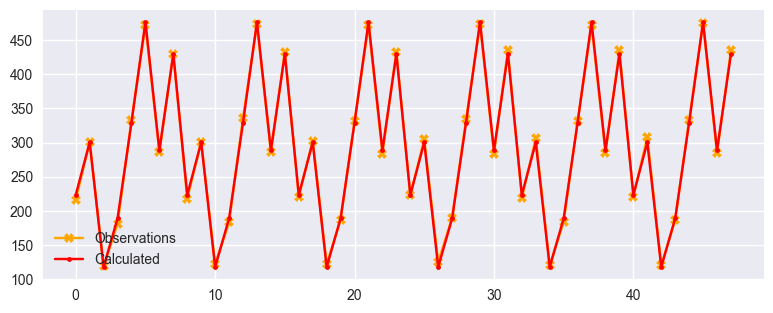

In [220]:
plt.plot(data_regression.y, color='orange', marker='X', label='Observations')
plt.plot(model.fittedvalues, color='red', marker='.', label='Calculated')
plt.legend(loc='best')
plt.show()

In [221]:
model_test = smf.ols(formula='y ~ A_release + B_firing + E_pin', data=data_regression).fit()

print(model_test.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     298.2
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           3.05e-29
Time:                        18:45:54   Log-Likelihood:                -221.16
No. Observations:                  48   AIC:                             450.3
Df Residuals:                      44   BIC:                             457.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -460.7946     62.079     -7.423      0.0

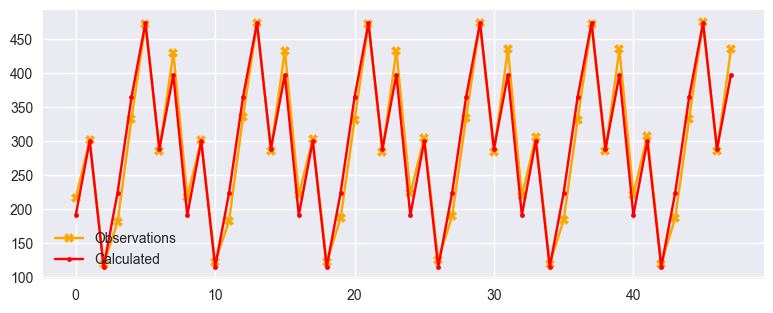

In [222]:
plt.plot(data_regression.y, color='orange', marker='X', label='Observations')
plt.plot(model_test.fittedvalues, color='red', marker='.', label='Calculated')
plt.legend(loc='best')
plt.show()

### Checking the weakest point from the model

The point which will assess if this 2-factor model is good or a 3-factor model might be required is the point corresponding to the midpoint among the variable bounds

In [223]:
new_data = pd.DataFrame({
    'A_release': [np.mean([150, 180])],
    'B_firing': [np.mean([110, 130])],  # If possible, fix it (conclusion of standard deviatin analysis)
    'E_pin': [np.mean([130, 200])]
})

display(model.get_prediction(new_data).summary_frame(alpha=0.05))
print(f'A_release: {np.mean([150, 180])},  , B_firing:  {np.mean([110, 130])}, E_pin:  {np.mean([130, 200])}')

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,294.354167,0.645899,293.049747,295.658586,285.223232,303.485102


A_release: 165.0,  , B_firing:  120.0, E_pin:  165.0


Going to the model, the y value observed is something close to 330.

The prediction is quite far away (predicted: 294).

This means that the model might require a refining step, by running a 3 factor experiment.

Other workaround, used here, is to calculate the predictions forcing the algorithm to search solutions close to the bounds of the variables.

It will be showed below that this solution has proven successful to model this experiment.

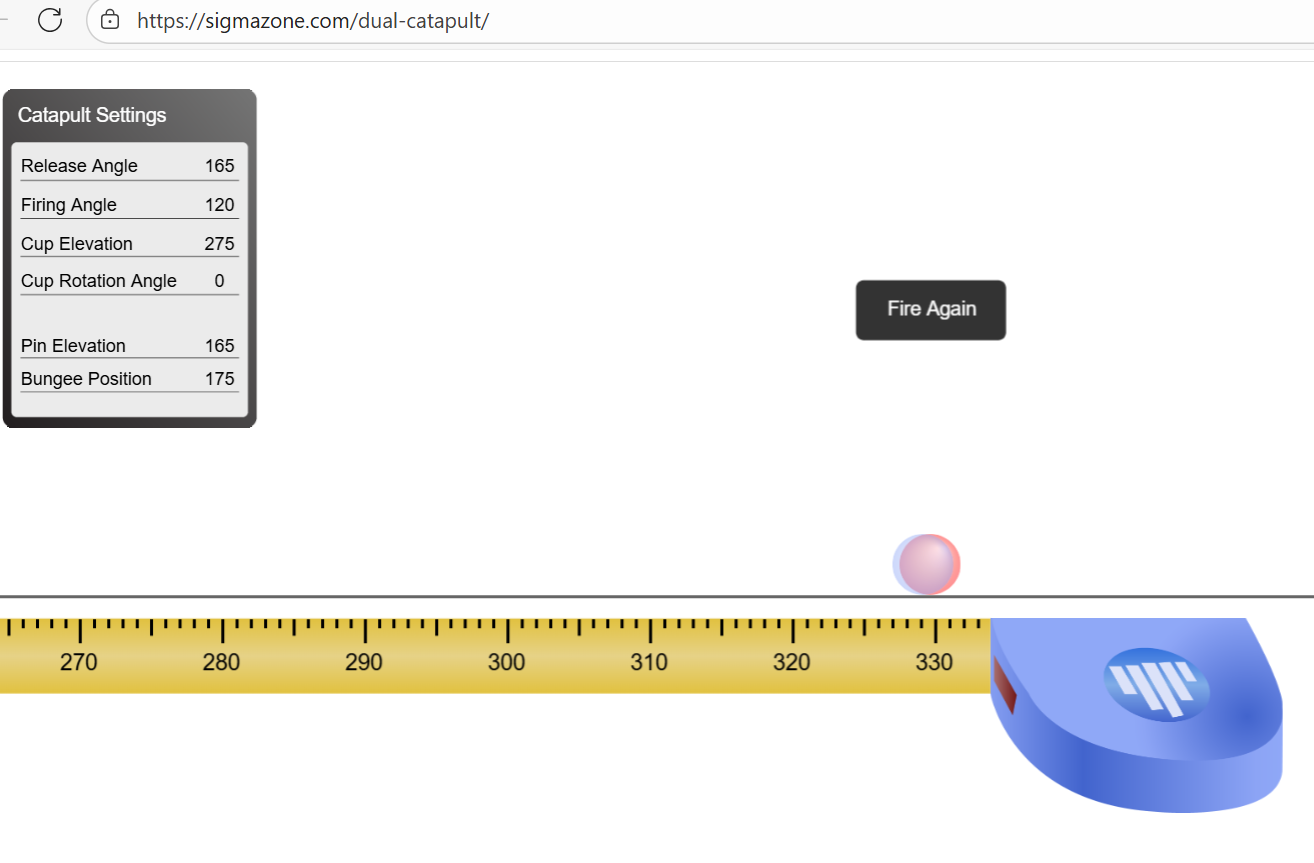

#### Checking normality of residuals

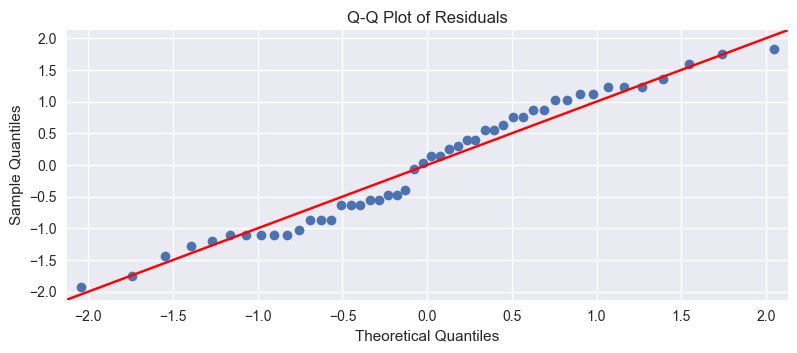

In [224]:
fig = sm.qqplot(model.resid, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

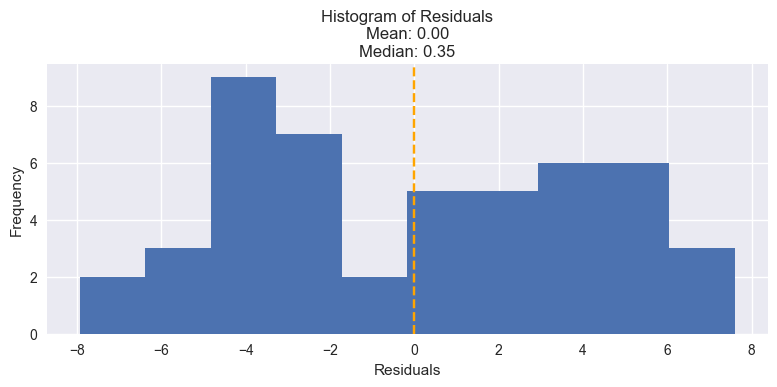

A high p-value implies residuals are likely normal:
 Omnibus test: 0.0102
 Jarque-Bera test: 0.2646


In [225]:
plt.hist(model.resid)
plt.axvline(model.resid.mean(), color='orange', linestyle='--')
plt.title(f'Histogram of Residuals\nMean: {model.resid.mean():,.2f}\nMedian: {model.resid.median():,.2f}')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

jb_test = jarque_bera(model.resid)
omni_test = omni_normtest(model.resid)
print('A high p-value implies residuals are likely normal:')
print(" Omnibus test:", round(omni_test[1], 4))
print(" Jarque-Bera test:", round(jb_test[1], 4))

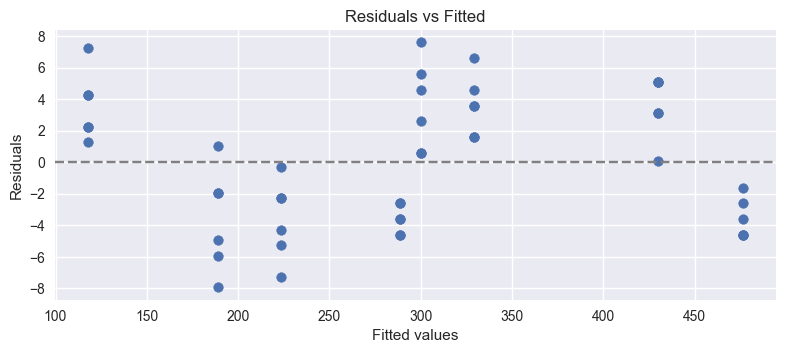

In [226]:
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

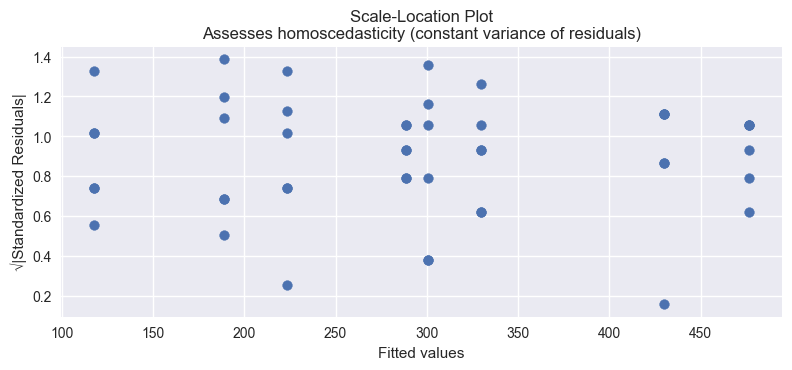

In [227]:
standardized_resid = model.get_influence().resid_studentized_internal
plt.scatter(model.fittedvalues, np.sqrt(np.abs(standardized_resid)))
plt.xlabel("Fitted values")
plt.ylabel("√|Standardized Residuals|")
plt.title("Scale-Location Plot\nAssesses homoscedasticity (constant variance of residuals)")
plt.show()

## Predictions

Attention should be given to formatting input data

* Fixed process input variables:
  * Factor D_cup_r: 0 (to keep process variance low)
  * Factor C_cup_e: 275
  * Factor F_bungee: 175 
* Variable process input variables:
  * Factor A_release: 150 to 180
  * Factor B_firing: 110 to 130
  * Factor E_pin: 130 to 200 

Remember that outside this range of y, the model might not work

In [228]:
print(f'Min y: {model.fittedvalues.min():,.2f}')
print(f'Max y: {model.fittedvalues.max():,.2f}')

Min y: 117.73
Max y: 476.60


In [229]:
new_data = pd.DataFrame({
    'A_release': [150],
    'B_firing': [130],  # If possible, fix it (conclusion of standard deviatin analysis)
    'E_pin': [130]
})

display(model.get_prediction(new_data).summary_frame(alpha=0.05))

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,117.729167,1.708888,114.277998,121.180336,108.055334,127.402999


Alternatively, it is possible to get only the target values

In [230]:
model.predict(new_data)

0    117.729167
dtype: float64

### Algorithm to discover the input variables given a target variable

Key: the closer the suggested input variables to their bounds, the lower will be the influence of non-linearity in the predictions

Please enter the desired output value (target_y) and run the code

In [231]:
##############################
# INPUT
# Desired output value
target_y = 329

##############################

# Define bounds for each variable
bounds = [
    (150, 180),  # A_release (fixed)
    (110, 130),  # B_firing
    (130, 200)   # E_pin
]

# Penalty weight (adjust to control influence of proximity)
penalty_weight = 2.0

# Objective function: prediction error + proximity penalty
def objective(x):
    A_release, B_firing, E_pin = x

    # Prediction part
    input_data = {
        'A_release': [A_release],
        'B_firing': [B_firing],
        'E_pin': [E_pin],
        'A_release:B_firing': [A_release * B_firing],
        'A_release:E_pin': [A_release * E_pin],
        'B_firing:E_pin': [B_firing * E_pin]
    }
    y_pred = model.predict(input_data)[0]
    error = (y_pred - target_y)**2

    # Proximity penalty: distance to nearest bound
    proximity = (
        min(abs(B_firing - bounds[1][0]), abs(B_firing - bounds[1][1])) +
        min(abs(E_pin - bounds[2][0]), abs(E_pin - bounds[2][1]))
    )

    return error + penalty_weight * proximity

# Initial guess
initial_guess = [150, 120, 165]

# Run optimization
result = minimize(objective, initial_guess, bounds=bounds)

# Output results
estimated_inputs = result.x
print(f"Estimated values for target y={target_y}:")
print(f"A_release = {estimated_inputs[0]:.4f}")
print(f"B_firing  = {estimated_inputs[1]:.4f}")
print(f"E_pin     = {estimated_inputs[2]:.4f}")

Estimated values for target y=329:
A_release = 158.8101
B_firing  = 112.1103
E_pin     = 190.0272


Fine-tune the input values, as process simulating website only accepts integer values

In [232]:
new_data = pd.DataFrame({
    'A_release': [np.mean([150, 180])],
    'B_firing': [np.mean([110, 130])],  # If possible, fix it (conclusion of standard deviatin analysis)
    'E_pin': [np.mean([130, 200])]
})

display(model.get_prediction(new_data).summary_frame(alpha=0.05))

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,294.354167,0.645899,293.049747,295.658586,285.223232,303.485102


In [233]:
new_data

,A_release,B_firing,E_pin
0,165.0,120.0,165.0


In [234]:
def estimate_inputs_for_y_range(y_min, y_max, model):
    # Define bounds for each variable
    bounds = [
        (150, 180),  # A_release (fixed)
        (110, 130),  # B_firing
        (130, 200)   # E_pin
    ]

    # Penalty weight
    penalty_weight = 2.0

    # Initial guess
    initial_guess = [150, 120, 165]

    # Store results
    records = []

    for target_y in range(y_min, y_max + 1):
        # Objective function
        def objective(x):
            A_release, B_firing, E_pin = x
            input_data = {
                'A_release': [A_release],
                'B_firing': [B_firing],
                'E_pin': [E_pin],
                'A_release:B_firing': [A_release * B_firing],
                'A_release:E_pin': [A_release * E_pin],
                'B_firing:E_pin': [B_firing * E_pin]
            }
            y_pred = model.predict(input_data)[0]
            error = (y_pred - target_y)**2
            proximity = (
                min(abs(B_firing - bounds[1][0]), abs(B_firing - bounds[1][1])) +
                min(abs(E_pin - bounds[2][0]), abs(E_pin - bounds[2][1]))
            )
            return error + penalty_weight * proximity

        # Run optimization
        result = minimize(objective, initial_guess, bounds=bounds)
        estimated_inputs = result.x

        # Store results
        records.append({
            'y': target_y,
            'A_release': estimated_inputs[0],
            'B_firing': estimated_inputs[1],
            'E_pin': estimated_inputs[2]
        })

    # Create a single DataFrame
    df = pd.DataFrame(records)
    return df

In [235]:
result_model_prediction_df = estimate_inputs_for_y_range(120, 475, model)

display(result_model_prediction_df)

,y,A_release,B_firing,E_pin
0,120,150.398683,130.0,130.0
1,121,150.574250,130.0,130.0
2,122,150.749817,130.0,130.0
3,123,150.925384,130.0,130.0
4,124,151.100951,130.0,130.0
...,...,...,...,...
351,471,179.045874,110.0,200.0
352,472,179.216127,110.0,200.0
353,473,179.386380,110.0,200.0
354,474,179.556633,110.0,200.0


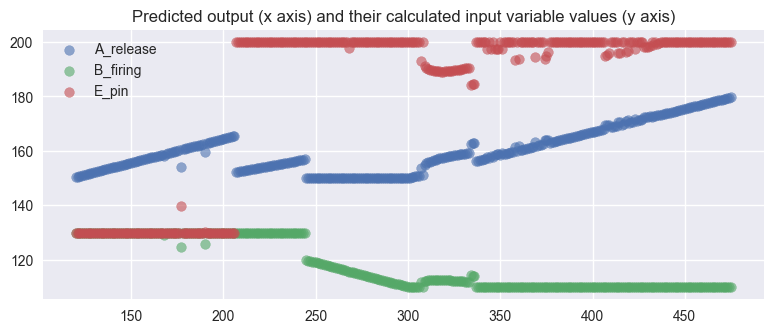

,y,A_release,B_firing,E_pin
0,120,150.398683,130.0,130.0
1,121,150.574250,130.0,130.0
2,122,150.749817,130.0,130.0
3,123,150.925384,130.0,130.0
4,124,151.100951,130.0,130.0
...,...,...,...,...
351,471,179.045874,110.0,200.0
352,472,179.216127,110.0,200.0
353,473,179.386380,110.0,200.0
354,474,179.556633,110.0,200.0


In [236]:
plt.scatter(result_model_prediction_df.y, result_model_prediction_df.A_release, label='A_release', alpha=0.6)
plt.scatter(result_model_prediction_df.y, result_model_prediction_df.B_firing, label='B_firing', alpha=0.6)
plt.scatter(result_model_prediction_df.y, result_model_prediction_df.E_pin, label='E_pin', alpha=0.6)
plt.legend(loc='best')
plt.title('Predicted output (x axis) and their calculated input variable values (y axis)')
plt.show()
display(result_model_prediction_df)

In [237]:
filter = ((result_model_prediction_df.y >= 250) & (result_model_prediction_df.y <= 300) )
result_model_prediction_df.loc[filter]

,y,A_release,B_firing,E_pin
130,250,150.0,119.010792,200.00000
131,251,150.0,118.831353,200.00000
132,252,150.0,118.651914,200.00000
133,253,150.0,118.472474,200.00000
134,254,150.0,118.293035,200.00000
135,255,150.0,118.113596,200.00000
136,256,150.0,117.934157,200.00000
137,257,150.0,117.754717,200.00000
138,258,150.0,117.575279,200.00000
139,259,150.0,117.395839,200.00000


### Output variable. Marginal mean plots

This may help to fine-tune model data

In [238]:
data

,run_count,A_release,B_firing,E_pin
0,1,150,110,130
1,2,150,110,200
2,3,150,130,130
3,4,150,130,200
4,5,180,110,130
5,6,180,110,200
6,7,180,130,130
7,8,180,130,200


In [239]:
data['y_mean'] = [0] * run_number

In [240]:
for i in data.run_count.tolist():
    data.loc[data.run_count == i, 'y_mean'] = np.mean(globals()[f'run_{i}'])

C:\Users\fc2\AppData\Local\Temp\ipykernel_16272\911045070.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '219.66666666666666' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data.run_count == i, 'y_mean'] = np.mean(globals()[f'run_{i}'])


In [241]:
worksheet = data.iloc[:,1:]

In [242]:
worksheet

,A_release,B_firing,E_pin,y_mean
0,150,110,130,219.666667
1,150,110,200,304.000000
2,150,130,130,121.333333
3,150,130,200,185.333333
4,180,110,130,333.000000
5,180,110,200,473.000000
6,180,130,130,285.000000
7,180,130,200,433.500000


In [243]:
data_analysis = pd.DataFrame(
                            {
                                'min_factor': [worksheet[i].min() for i in worksheet.columns[:-1]],
                                'max_factor': [worksheet[i].max() for i in worksheet.columns[:-1]]
                             }, 
                             index=worksheet.columns[:-1]
                            )

In [244]:
y_mean_min_of_factor = []
for factor in data_analysis.index.tolist():
    min_value_of_factor = data_analysis.loc[factor, 'min_factor']
    y_mean_min = worksheet.loc[worksheet[factor] == min_value_of_factor].y_mean.mean()
    y_mean_min_of_factor.append(y_mean_min)

y_mean_max_of_factor = []
for factor in data_analysis.index.tolist():
    max_value_of_factor = data_analysis.loc[factor, 'max_factor']
    y_mean_max = worksheet.loc[worksheet[factor] == max_value_of_factor].y_mean.mean()
    y_mean_max_of_factor.append(y_mean_max)

data_analysis['y_mean_min_factor'] = y_mean_min_of_factor
data_analysis['y_mean_max_factor'] = y_mean_max_of_factor

data_analysis['delta_abs'] = abs(data_analysis.y_mean_min_factor - data_analysis.y_mean_max_factor)

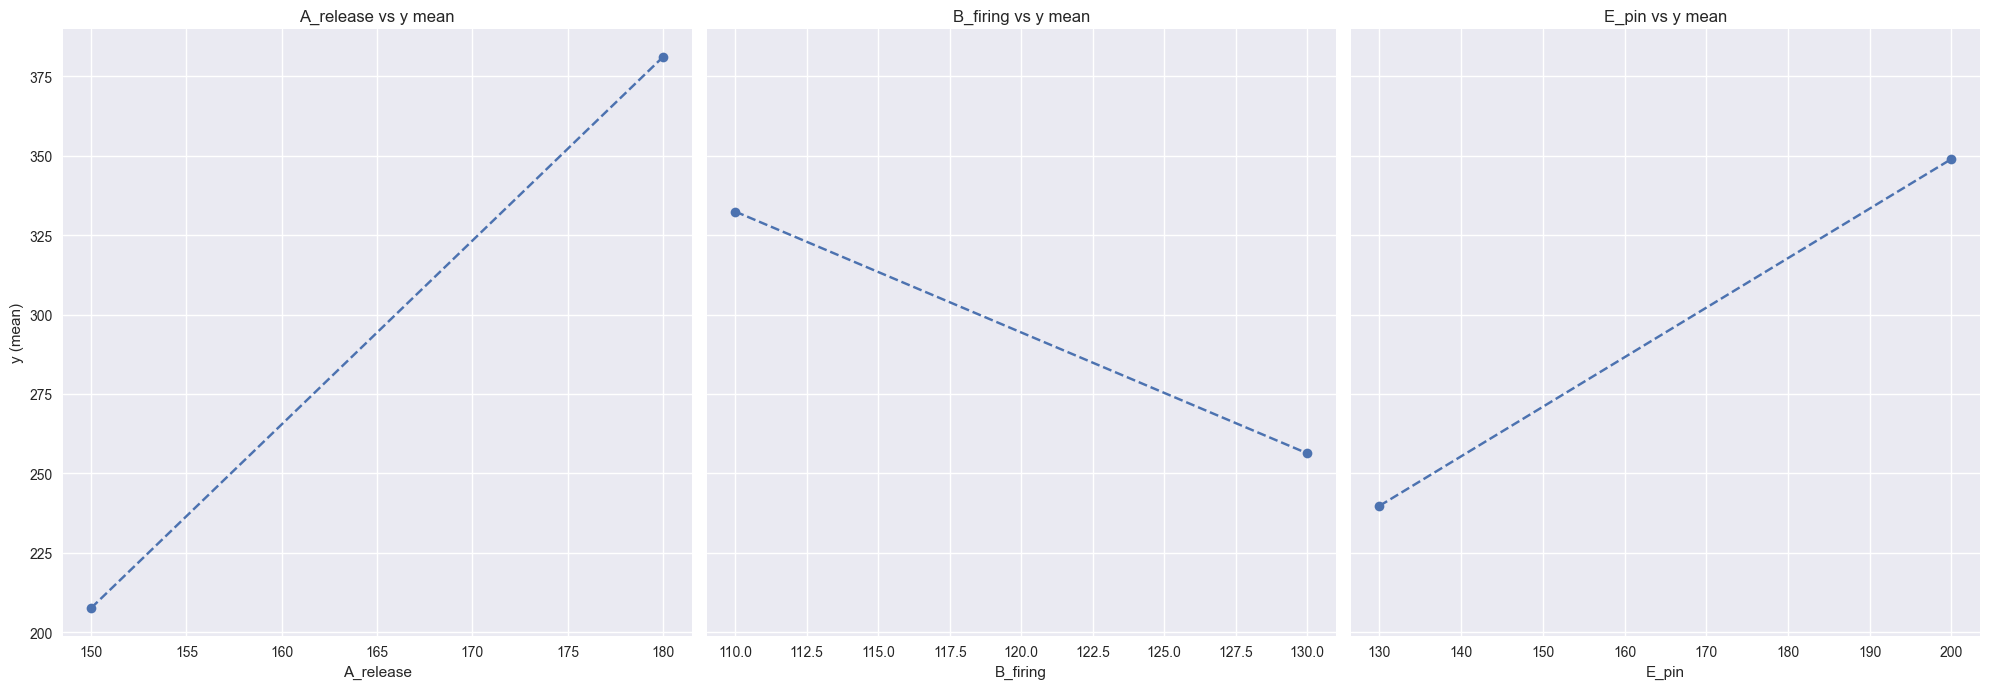

,min_factor,max_factor,y_mean_min_factor,y_mean_max_factor,delta_abs
A_release,150,180,207.583333,381.125000,173.541667
E_pin,130,200,239.750000,348.958333,109.208333
B_firing,110,130,332.416667,256.291667,76.125000


In [245]:
fig, axes = plt.subplots(1, len(data_analysis.index.tolist()), figsize=(20, 7), sharey=True)

for i, factor in enumerate(data_analysis.index.tolist()):
    filtered = data_analysis.loc[factor]
    axes[i].plot(
        [filtered.min_factor, filtered.max_factor],
        [filtered.y_mean_min_factor, filtered.y_mean_max_factor],
        marker='o', linestyle = '--'
    )
    axes[i].set_title(f'{factor} vs y mean')
    axes[i].set_xlabel(factor)
    if i == 0:
        axes[i].set_ylabel('y (mean)')

plt.tight_layout()
plt.show()
print()
display(data_analysis.sort_values(by='delta_abs', ascending= False))

Instructions for fine-tuning of these input variables to get a given target value

* To increase output variable:
  * Increase A_release: biggest effect
  * Increase E_pin: next bigger effect
  * Reduce B_firing: smallest effect

# Conclusions

A complex process has been analysed using design of experiments to:
* Screen the key input variables
* Model the process to predict input variable values to reach a desired process output

* Although the model is not 100% perfect, it gives an excellent first shot to find the input variables that give the desired target value

* These variables have ben set with fixed values to model this process:
  * Factor: D_cup_r: 0 (to keep process variance low)
  * Factor: C_cup_e: 275 (a mean value of the two extremes tested, lacking of other potential selection criteria)
  * Factor: F_bungee: 175 (a mean value of the two extremes tested, lacking of other potential selection criteria)
* The linear regression model shows interactions among the 3 free variables chosen:
  * Factor: A_release
  * Factor: B_firing
  * Factor: E_pin

* Another linear regression model without interactions among the 3 free variables just showed quite similar results
* To deal better with quite probable appearing variable non-linearities, the optimization algorithm penalizes free variable values far from their bounds (min and max values). This has proven to be an essential element of this model.
* This algorithmic approach has prevented for having to develop an new 3-factor model.

## Predictions, revisited

Maximizing with algorithm all the available data, without need to get more data.

The regression model remains the same, therefore all the former analysis remains valid.

The algorithm gets slightly modified, to allow results which:

* Try to reach the objective variable
* Being the closest possible of the input variable bounds, to avoid non-linearity space
* Allowing only input values which can be actually be set in the simulator

Cause: the input variables in the model only allow integer (0 decimal cases) values.

In [246]:
from scipy.optimize import dual_annealing

def new_estimate_inputs_for_y_range(y_min, y_max, model):
    # Define bounds for each variable
    bounds = [
        (150, 180),  # A_release (fixed)
        (110, 130),  # B_firing
        (130, 200)   # E_pin
    ]

    # Penalty weight
    penalty_weight = 2.0

    # Store results
    records = []

    for target_y in range(y_min, y_max + 1):
        # Objective function with integer rounding
        def objective(x):
            A_release = int(round(x[0]))
            B_firing = int(round(x[1]))
            E_pin = int(round(x[2]))

            input_data = {
                'A_release': [A_release],
                'B_firing': [B_firing],
                'E_pin': [E_pin],
                'A_release:B_firing': [A_release * B_firing],
                'A_release:E_pin': [A_release * E_pin],
                'B_firing:E_pin': [B_firing * E_pin]
            }

            y_pred = model.predict(input_data)[0]
            error = (y_pred - target_y)**2
            proximity = (
                min(abs(B_firing - bounds[1][0]), abs(B_firing - bounds[1][1])) +
                min(abs(E_pin - bounds[2][0]), abs(E_pin - bounds[2][1]))
            )
            return error + penalty_weight * proximity

        # Run optimization using dual_annealing
        result = dual_annealing(objective, bounds)
        estimated_inputs = [int(round(x)) for x in result.x]

        # Store results
        records.append({
            'y': target_y,
            'A_release': estimated_inputs[0],
            'B_firing': estimated_inputs[1],
            'E_pin': estimated_inputs[2]
        })

    # Create a single DataFrame
    df = pd.DataFrame(records)
    return df

Time-consuming!

In [247]:
new_result_model_prediction_df = new_estimate_inputs_for_y_range(120, 475, model)

display(new_result_model_prediction_df)

,y,A_release,B_firing,E_pin
0,120,150,130,131
1,121,150,130,132
2,122,151,130,130
3,123,151,130,130
4,124,151,130,130
...,...,...,...,...
351,471,179,110,200
352,472,179,110,200
353,473,180,111,200
354,474,180,111,200


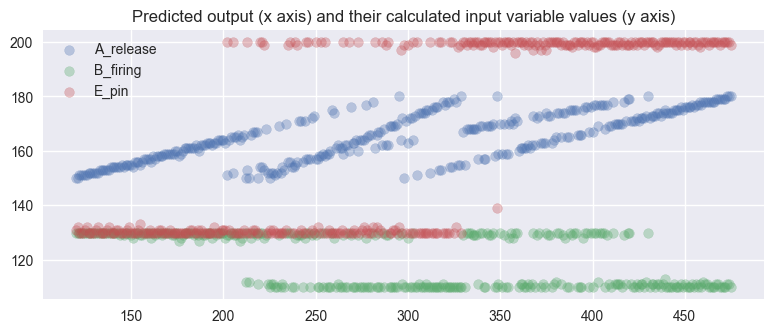

,y,A_release,B_firing,E_pin
0,120,150,130,131
1,121,150,130,132
2,122,151,130,130
3,123,151,130,130
4,124,151,130,130
...,...,...,...,...
351,471,179,110,200
352,472,179,110,200
353,473,180,111,200
354,474,180,111,200


In [248]:
plt.scatter(new_result_model_prediction_df.y, new_result_model_prediction_df.A_release, label='A_release', alpha=0.33)
plt.scatter(new_result_model_prediction_df.y, new_result_model_prediction_df.B_firing, label='B_firing', alpha=0.33)
plt.scatter(new_result_model_prediction_df.y, new_result_model_prediction_df.E_pin, label='E_pin', alpha=0.33)
plt.legend(loc='best')
plt.title('Predicted output (x axis) and their calculated input variable values (y axis)')
plt.show()
display(new_result_model_prediction_df)

Helping to choose the best parameters for a first shoot to target

In [249]:
new_result_model_prediction_df['bound_A_release'] = new_result_model_prediction_df.A_release.isin(bounds[0])

new_result_model_prediction_df['bound_B_firing'] = new_result_model_prediction_df.B_firing.isin(bounds[1])

new_result_model_prediction_df['bound_E_pin'] = new_result_model_prediction_df.E_pin.isin(bounds[2])

new_result_model_prediction_df['bound_count'] = new_result_model_prediction_df[['bound_A_release', 'bound_B_firing', 'bound_E_pin']].sum(axis=1)

Hint:

Pick your goal

From the table, pick a close value to your goal with the highest 'bond_count' value and/or the shortest distance to the bounds.

Test the suggested values in the simulator

Remake calculation, considering to pick a close value to your goal with the highest 'bond_count' value and/or the shortest distance to the bounds.

In [252]:
y_goal = 425

filter = ((new_result_model_prediction_df.y >= y_goal - 20) & (new_result_model_prediction_df.y <= y_goal + 20) &
         (new_result_model_prediction_df.bound_count >= 2)
         )
new_result_model_prediction_df.loc[filter]

,y,A_release,B_firing,E_pin,bound_A_release,bound_B_firing,bound_E_pin,bound_count
285,405,177,130,200,False,True,True,2
286,406,177,130,200,False,True,True,2
287,407,168,110,200,False,True,True,2
303,423,171,110,200,False,True,True,2
305,425,171,110,200,False,True,True,2
310,430,180,130,200,True,True,True,3
311,431,172,110,200,False,True,True,2
317,437,173,110,200,False,True,True,2
320,440,174,110,200,False,True,True,2
321,441,174,110,200,False,True,True,2


This exhibition of the solution space has been left a bit 'raw cooked' in order to give the user freedom to choose their set of parameters which will reach the target, wherever there are options to choose, like in the example below:

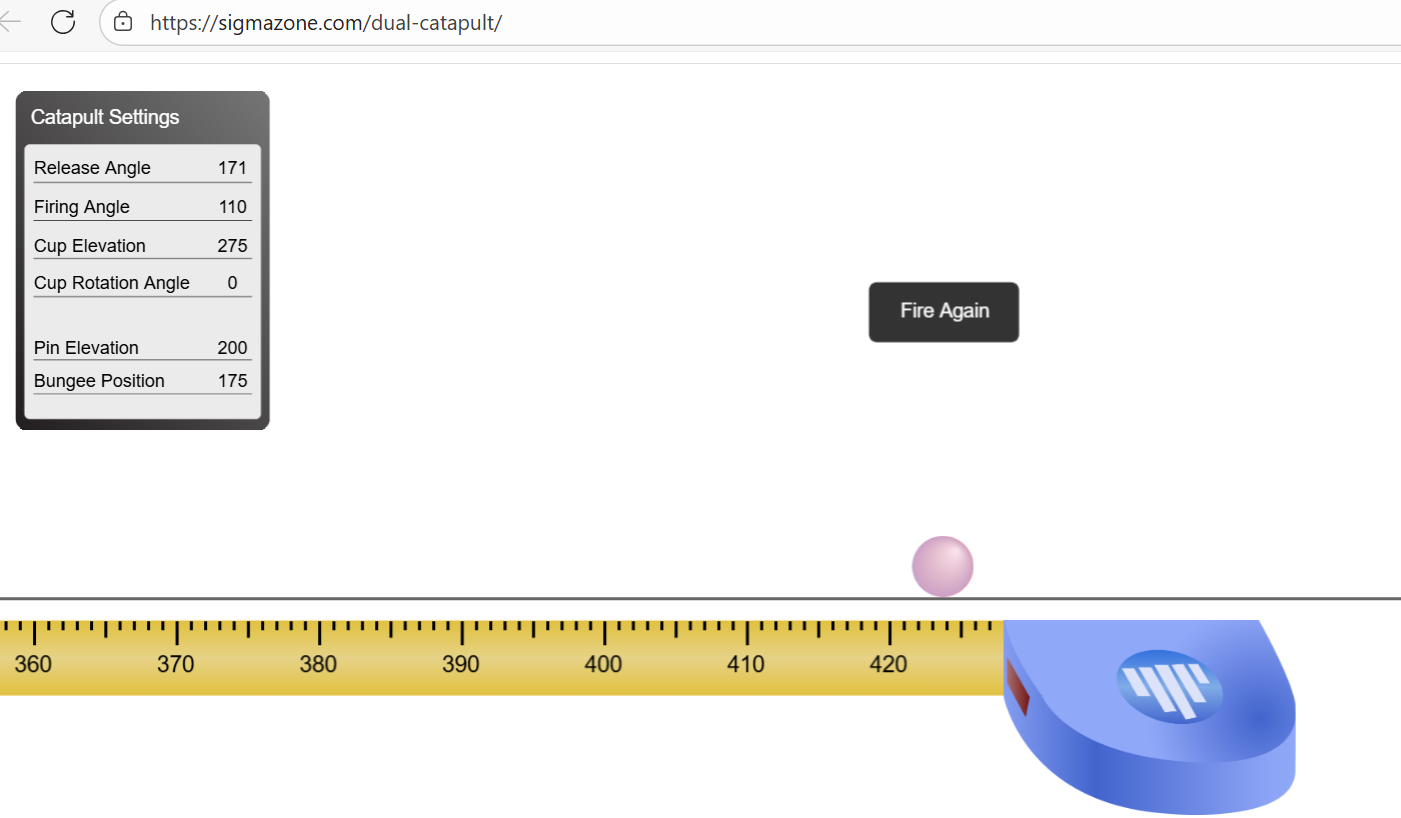

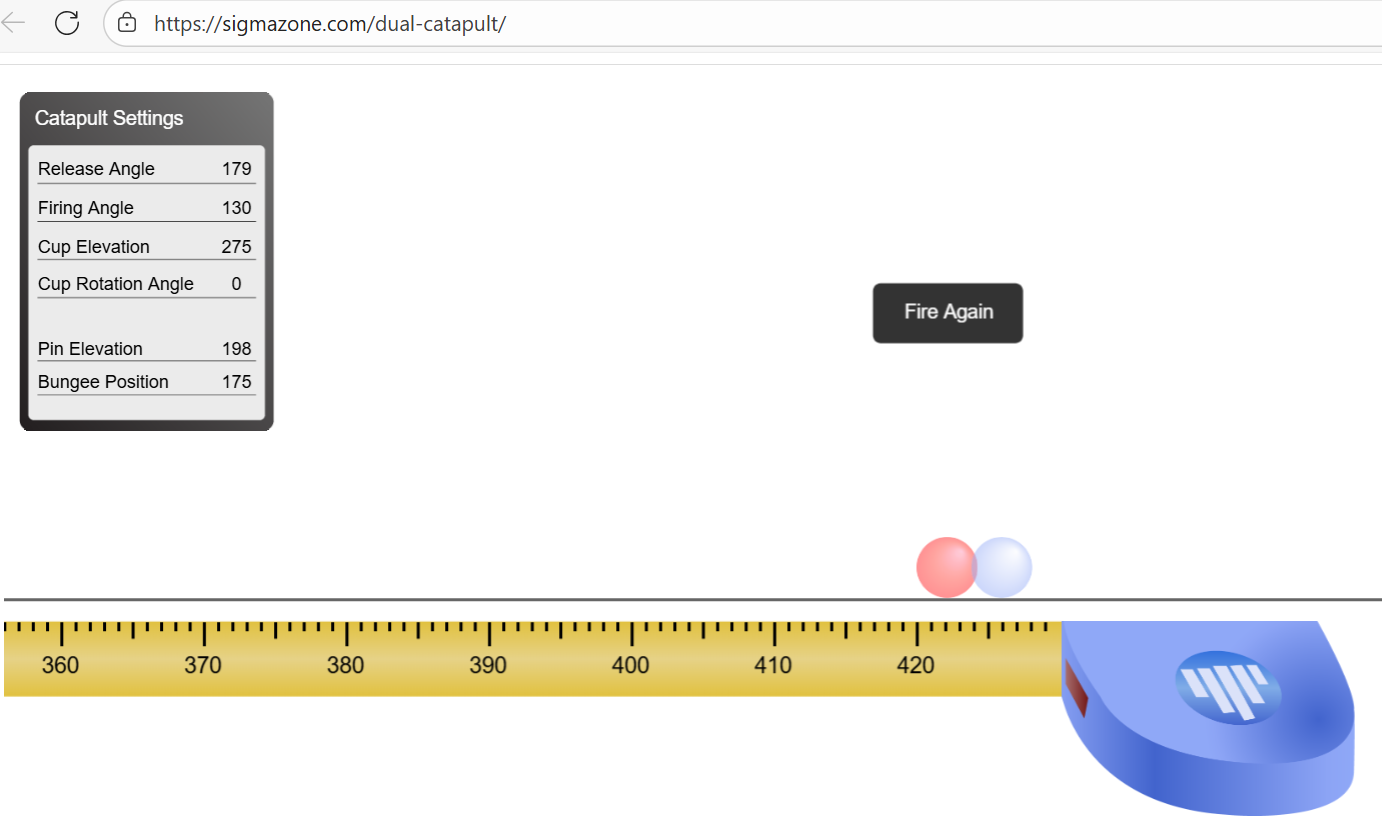